In [0]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as opt
import torchvision.transforms as transforms
from torchvision import models
import copy

In [0]:
transform_train = transforms.Compose(
    [
     transforms.RandomResizedCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
transform_test = transforms.Compose(
    [
     transforms.RandomResizedCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

In [0]:
trainset = torchvision.datasets.STL10(root='./data', transform=transform_train, download=True, split='train')
testset = torchvision.datasets.STL10(root='./data', transform=transform_test, download=True, split='test')

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [0]:
batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle= True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
dataiter = iter(trainloader)
inputs, labels = dataiter.next()
print(inputs.shape, labels.shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224]) torch.Size([4])
3


In [0]:
def imageshow(img):
  img = img.numpy() /2 +0.5
  plt.figure(figsize=(batch_size, 1))
  img = np.transpose(img, (1, 2, 0))
  plt.imshow(img)
  plt.show()

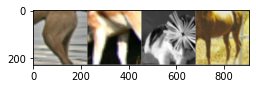

In [0]:
imgs, labels = next(iter(trainloader))
images = torchvision.utils.make_grid(imgs)
imageshow(images)

In [0]:
device= torch.device('cuda:0')
print(device)

cuda:0


In [0]:
snet = models.squeezenet1_0()

In [0]:
print(snet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [0]:
print(snet.classifier[1])

Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))


In [0]:
snet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))

In [0]:
print(snet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [0]:
snet = snet.to(device)
opt = opt.Adam(snet.parameters())
loss_fn = nn.CrossEntropyLoss()

In [0]:
def evaluation(dataloader, model):
  total, correct =0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    total+= labels.size(0)
    _, pred = torch.max(outputs, 1)
    correct+=(pred == labels).sum().item()
    return 100*correct/total

In [0]:
loss_arr =[]
epochs = 10
min_loss = 100
for epoch in range(epochs):
  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    opt.zero_grad()
    output = snet(inputs)
    loss = loss_fn(output, labels)
    loss.backward()
    opt.step()
    
    if min_loss > loss.item():
        min_loss = loss.item()
        best_model = copy.deepcopy(snet.state_dict())
        print('min loss: ', min_loss)
    
    del inputs, labels
    torch.cuda.empty_cache()
  loss_arr.append(loss.item())
print(evaluation(trainloader, snet), evaluation(testloader, snet))

min loss:  2.4154396057128906
min loss:  2.2982163429260254
0.0 25.0


In [0]:
snet.load_state_dict(best_model)

<All keys matched successfully>

In [0]:
print(evaluation(trainloader, snet), evaluation(testloader, snet))

0.0 0.0
